In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# sci-kit learn tools
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ShuffleSplit

In [110]:
df = pd.read_csv("data/diabetic_data.csv")

### Introduction

This dataset is from Virginia Commonwealth University and contains medical data for 101766 diabetes-related patients across 130 U.S. hospitals from 1999 to 2008. There are 49 features which include demographic, medical history, laboratory test, and medication prescription data. The response variable is whether or not the patient was readmitted to the hospital.

### Defining X (predictors) and y (response)

In [111]:
y = df['readmitted']
X = df.loc[:, df.columns != 'readmitted']

### Data Cleaning

* Replacing 'questions marks' with NaN in the dataset.
* Converting yes/no columns to binary.

In [112]:
# replace question marks with NaN
features = ['weight', 'race', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult']

for f in features:
    X.loc[X[f] == '?', f] = np.NaN


# convert two-factor (e.g., yes/no) columns to boolean
X.loc[X.diabetesMed == 'No', 'diabetesMed'] = 0
X.loc[X.diabetesMed == 'Yes', 'diabetesMed'] = 1

X.loc[X.change == 'No', 'change'] = 0
X.loc[X.change == 'Ch', 'change'] = 1

X.loc[X.gender == 'Male', 'gender'] = 0
X.loc[X.gender == 'Female', 'gender'] = 1
X.loc[X.gender == 'Unknown/Invalid', 'gender'] = 2

X.loc[X.tolbutamide == 'No', 'tolbutamide'] = 0
X.loc[X.tolbutamide == 'Steady', 'tolbutamide'] = 1

### Assessing Missing Data

Using Python package [missingno](https://github.com/ResidentMario/missingno), we can easily identify the features with excessive NA's. As you can see in the calcuations below, the features with most NA's are **weight** (~97% NA's) and **medical_specialty** (49% NA's).

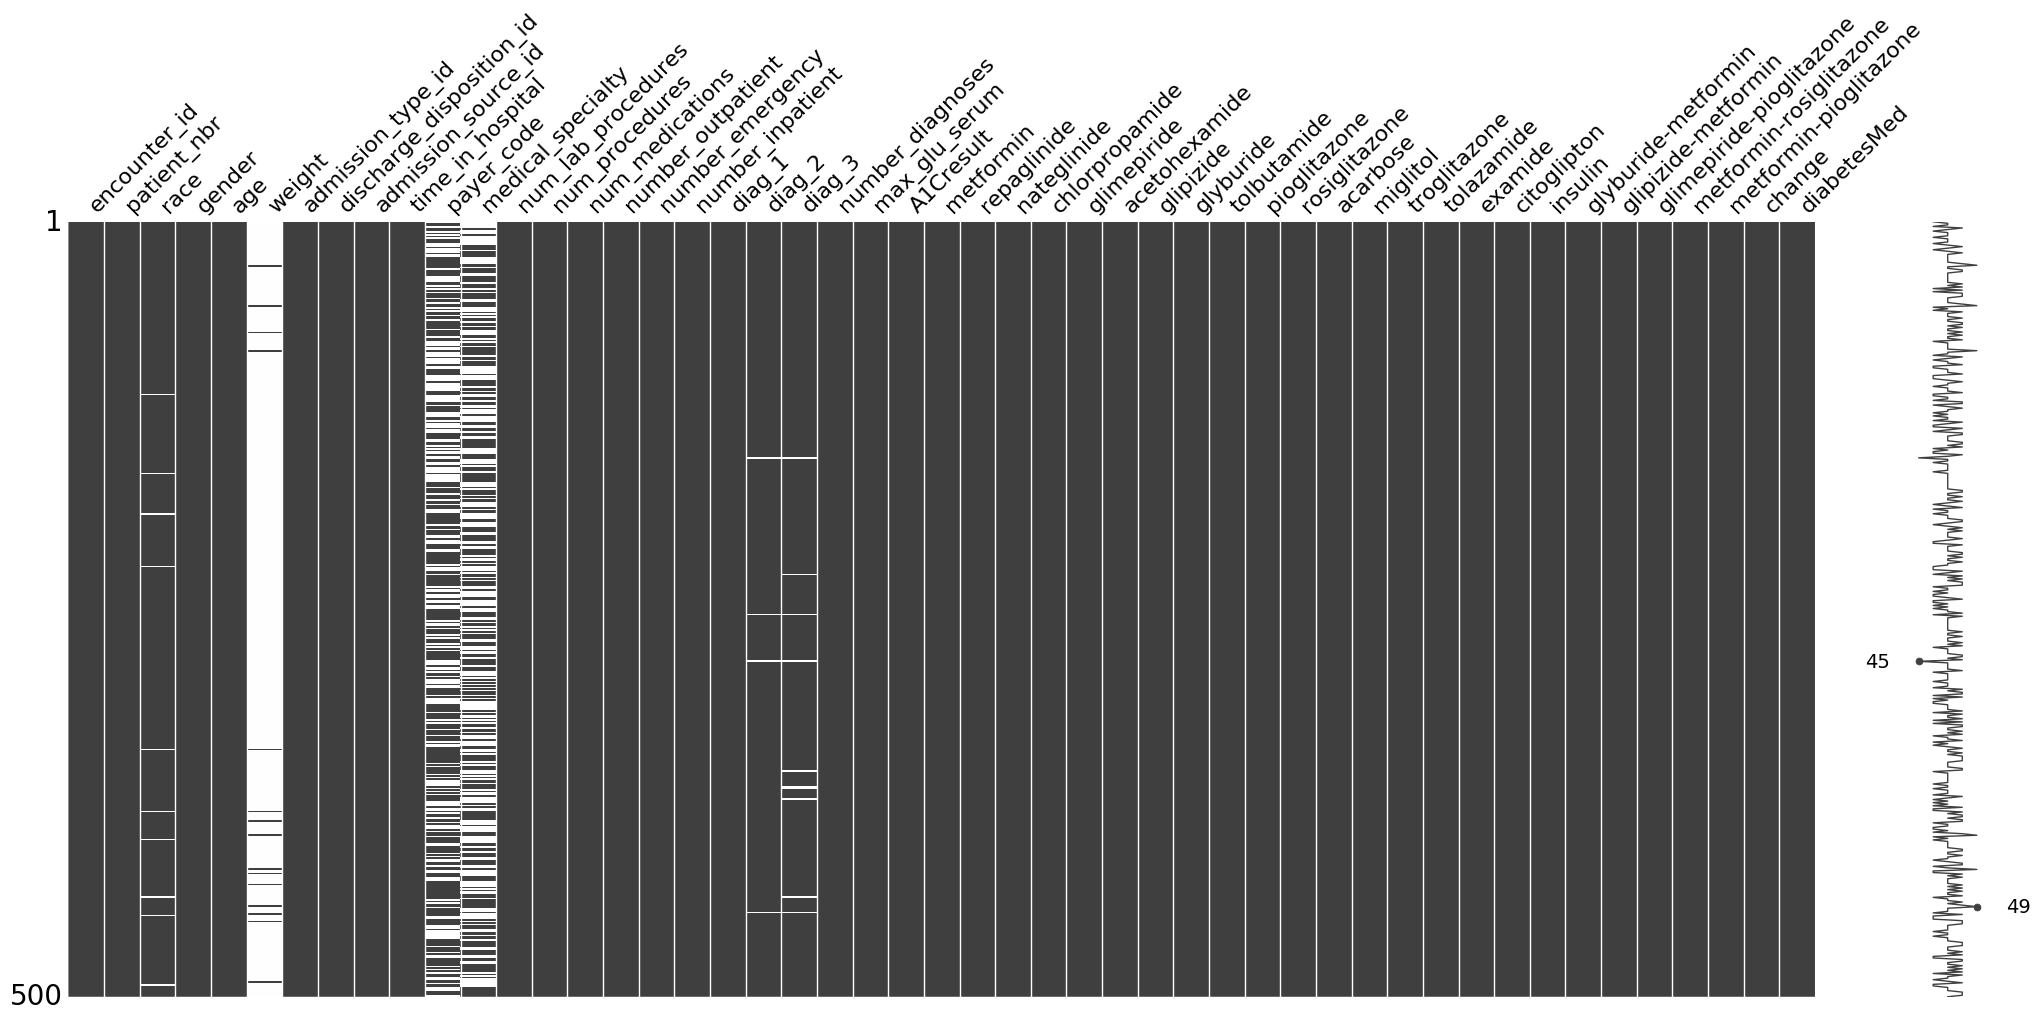

In [113]:
import missingno as msno
%matplotlib inline
msno.matrix(X.sample(500))

In [114]:
print('Proportion of NA values in weight column:',
      X['weight'].isnull().sum()/len(X['weight']))
print('Proportion of NA values in medical_specialty column:',
      X['medical_specialty'].isnull().sum()/len(X['medical_specialty']))
print('Proportion of NA values in race column:',
      X['race'].isnull().sum()/len(X['race']))

Proportion of NA values in weight column: 0.9685847925633315
Proportion of NA values in medical_specialty column: 0.49082208203132677
Proportion of NA values in race column: 0.022335554114340742


In [115]:
# generate visualization for categorical variables
features = df.columns.values[2:,]

rows = []
for f in features:
    if df[f].nunique() < 10:
        if df[f].dtype not in [np.dtype('float64'), np.dtype('int64')]:
            column = df.groupby(f)['encounter_id'].nunique()
            for i in range(column.shape[0]):
                row = {'feature':f, 'index':i, 'freq':column[i]}
                rows.append(row)

feature_freq = pd.DataFrame.from_dict(rows)

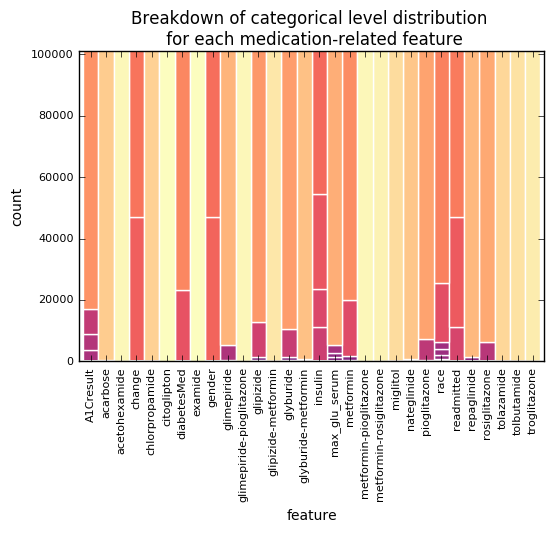

In [116]:
ax = feature_freq.pivot(index='feature',columns='freq',values='freq').plot.bar(stacked=True, edgecolor='white', linewidth='1', width=1, cmap='magma')
ax.legend_.remove()
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_title('Humidity',fontsize= 16)
plt.ylim(0,101000)
plt.title('Breakdown of categorical level distribution \n for each medication-related feature')
plt.ylabel('count')
plt.show()

### List of features with an extremely dominant feature (>98%)

The plot above represents the distribution of category levels for each categorical feature. The bars that are primarily one color (e.g., light orange or yellow) suggest that those features have one extremely dominant categorical level. Features with one dominant categorical level (98% or higher) are: 

In [117]:
feature_freq['proportion'] = feature_freq['freq']/len(df)
feature_freq.sort_values('proportion', ascending=False)
feature_propotions = feature_freq[feature_freq['proportion'] > 0.98]
feature_propotions['feature']

22                 repaglinide
26                 nateglinide
30              chlorpropamide
37               acetohexamide
47                 tolbutamide
58                    acarbose
62                    miglitol
65                troglitazone
67                  tolazamide
70                     examide
71                 citoglipton
77         glyburide-metformin
80         glipizide-metformin
82    glimepiride-pioglitazone
84     metformin-rosiglitazone
86      metformin-pioglitazone
Name: feature, dtype: object

Note: there were 2 features which only have one categorical level: `examide`, `citoglipton`.

These features having either a single categorical level **or** one extremely dominant level will be removed from predictor/feature dataframe. 

### Removing Features 

We will be removing 3 types of features from our model: 1) unique ID's, 2) have 97%+ missing data, and 3) have an extremely dominant categorical level. 

In [118]:
# pt 3: remove columns that are 1) unique ids, 2) have 97% missing data, or 3) have the same value for all patients
missing_data_feature = ['weight']
unique_id_features = ['payer_code', 'encounter_id', 'patient_nbr']
dominant_features = ['repaglinide', 'nateglinide', 'chlorpropamide','acetohexamide',
                      'tolbutamide','acarbose','miglitol','troglitazone','tolazamide',
                      'examide','citoglipton','glyburide-metformin','glipizide-metformin',
                      'glimepiride-pioglitazone','metformin-rosiglitazone',
                      'metformin-pioglitazone']

features_removed = np.concatenate([missing_data_feature, unique_id_features, dominant_features])

X.drop(features_removed, axis = 1, inplace = True)

count = len(X.columns.values)

print('Remaining # of features:', count)

Remaining # of features: 29


### Generate Dummy Variables for Categorical Features

In [119]:
cols = X.columns.values

In [120]:
items = ['age','race', 'max_glu_serum', 'A1Cresult',
       'metformin', 'glimepiride', 'glipizide', 'glyburide',
       'pioglitazone', 'rosiglitazone', 'insulin', 'medical_specialty']

for i in items:
    X = pd.get_dummies(X, prefix=[i], columns=[i])

In [121]:
count = len(X.columns.values)

print('Number of features after implementation of dummy vars:', count)

Number of features after implementation of dummy vars: 140


Since `diag_1`, `diag_2`, and `diag_3` have over 700 categorical levels each, I have decided to encode these 3 categorical features instead of creating dummy variables. 

### Encoding Diagnosis-Related Categorical Variables

In [122]:
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()

# diag_1 = X['diag_1']
# diag_1 = diag_1.factorize()[0]
# diag_1 = le.fit_transform(diag_1)

# diag_2 = X['diag_2']
# diag_2 = diag_2.factorize()[0]
# diag_2 = le.fit_transform(diag_2)

# diag_3 = X['diag_1']
# diag_3 = diag_3.factorize()[0]
# diag_3 = le.fit_transform(diag_3)

In [124]:
X["diag_1"] = X["diag_1"].astype('category')
X["diag_1"] = X["diag_1"].cat.codes

X["diag_2"] = X["diag_2"].astype('category')
X["diag_2"] = X["diag_2"].cat.codes

X["diag_3"] = X["diag_3"].astype('category')
X["diag_3"] = X["diag_3"].cat.codes

### Testing out different models

#### 1) Random Forest Classifier

In [125]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = RandomForestClassifier(max_depth=20, random_state=42)
clf.fit(X_train, y_train)
print('Training accuracy:', clf.score(X_train, y_train))
print('Validation accuracy:', clf.score(X_test, y_test))

Training accuracy: 0.7733745948403561
Validation accuracy: 0.5679361581752672


In [126]:
split = ShuffleSplit(n_splits=5,test_size=.33,random_state=42)

depth = np.arange(7,20)

parameters = {'max_depth': depth}

search = GridSearchCV(RandomForestClassifier(), parameters, cv=split)
search.fit(X, y)
print('Best params:', search.best_params_)
print('Best score:', search.best_score_)

Best params: {'max_depth': 12}
Best score: 0.5779709972307417


In [107]:
clf = RandomForestClassifier(max_depth=14, random_state=42)
clf.fit(X_train, y_train)
print('Training accuracy', clf.score(X_train, y_train))
print('Test accuracy', clf.score(X_test, y_test))

ValueError: Unknown label type: 'unknown'

Random Forest Classification generates a training accuracy of 64% and test accuracy of 57%. 

In [127]:
bool_y = pd.DataFrame(df['readmitted'])

bool_y.loc[bool_y.readmitted != 'NO', 'readmitted'] = 1
bool_y.loc[bool_y.readmitted == 'NO', 'readmitted'] = 0
bool_y = bool_y['readmitted'].astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, bool_y, test_size=0.33, random_state=42)

clf = RandomForestClassifier(max_depth=14, random_state=42)
clf.fit(X_train, y_train)
print('Training accuracy', clf.score(X_train, y_train))
print('Test accuracy', clf.score(X_test, y_test))

Training accuracy 0.7135942976988399
Test accuracy 0.6274900991573117


In [135]:
bool_y = pd.DataFrame(df['readmitted'])

bool_y.loc[bool_y.readmitted != 'NO', 'readmitted'] = 1
bool_y.loc[bool_y.readmitted == 'NO', 'readmitted'] = 0
bool_y = bool_y['readmitted'].astype('int')


#### 2) Ridge Regression

In [140]:
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score

# using boolean response
X_train, X_test, y_train, y_test = train_test_split(X, bool_y, test_size=0.5, random_state=42)

split = ShuffleSplit(n_splits=5,test_size=.33,random_state=42)

c = np.arange(-6,2)
c_val = 10.**c

parameters = {'C': c_val}

search = GridSearchCV(LogisticRegression(penalty='l2'), parameters, cv=split)
search.fit(X, y)

print('Best params:', search.best_params_)
print('Best score:', search.best_score_)


# l1 = LogisticRegression(penalty='l1',C=1)
# l1.fit(X_train, y_train)
# #l1.coef_
# l1.score(X_test, y_test)


NameError: name 'LogisticRegression' is not defined

#### 3) Lasso Regression

#### 4) 